In [1]:
import pickle
from glob import glob

import cv2
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision.transforms.functional import gaussian_blur, resize
from tqdm import tqdm
from transformers import AutoModel, CLIPModel, CLIPProcessor
from usearch.index import Index


torch.set_grad_enabled(True)

#model = CLIPModel.from_pretrained(
#     "openai/clip-vit-large-patch14", device_map="cpu"  # , torch_dtype=torch.float16
# )
model = CLIPModel.from_pretrained(
    "laion/CLIP-ViT-H-14-laion2B-s32B-b79K", device_map="cpu"  # , torch_dtype=torch.float16
)
model.eval()
model.to("cpu")
processor = CLIPProcessor.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K")


def img2vec(image):
    # image_features = processor.image_processor(image, return_tensors="pt")
    image_features = (cv2.resize(image, (224, 224)).astype(np.float16) - 127) / 127
    image_features = torch.from_numpy(image_features).permute(2, 0, 1).unsqueeze(0)
    out = model.get_image_features(image_features.to("cpu"))
    out = out.squeeze().cpu().float().detach().numpy()
    return out


def txt2vec(text):
    text_features = processor.tokenizer(text, return_tensors="pt")
    out = model.get_text_features(text_features.input_ids.to("cpu"))
    out = out.squeeze().cpu().float().detach().numpy()
    return out

# Compute cosine similarity
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [2]:
## get png image list from dream_language folder

path = '../dream_language'
glob_path = path + '/*.png'

symbols_vecs = []
# create embedding for each image
for i, path in enumerate(glob(glob_path, recursive=True)):
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    vec = img2vec(image)
    symbols_vecs.append(vec)
    

In [ ]:
symbols_vecs = np.array(symbols_vecs)
print(symbols_vecs.shape)
# save the embeddings as csv
import pandas as pd
df = pd.DataFrame(symbols_vecs)
df.to_csv('symbols_visual_vecs.csv', index=False)

(11, 1024)


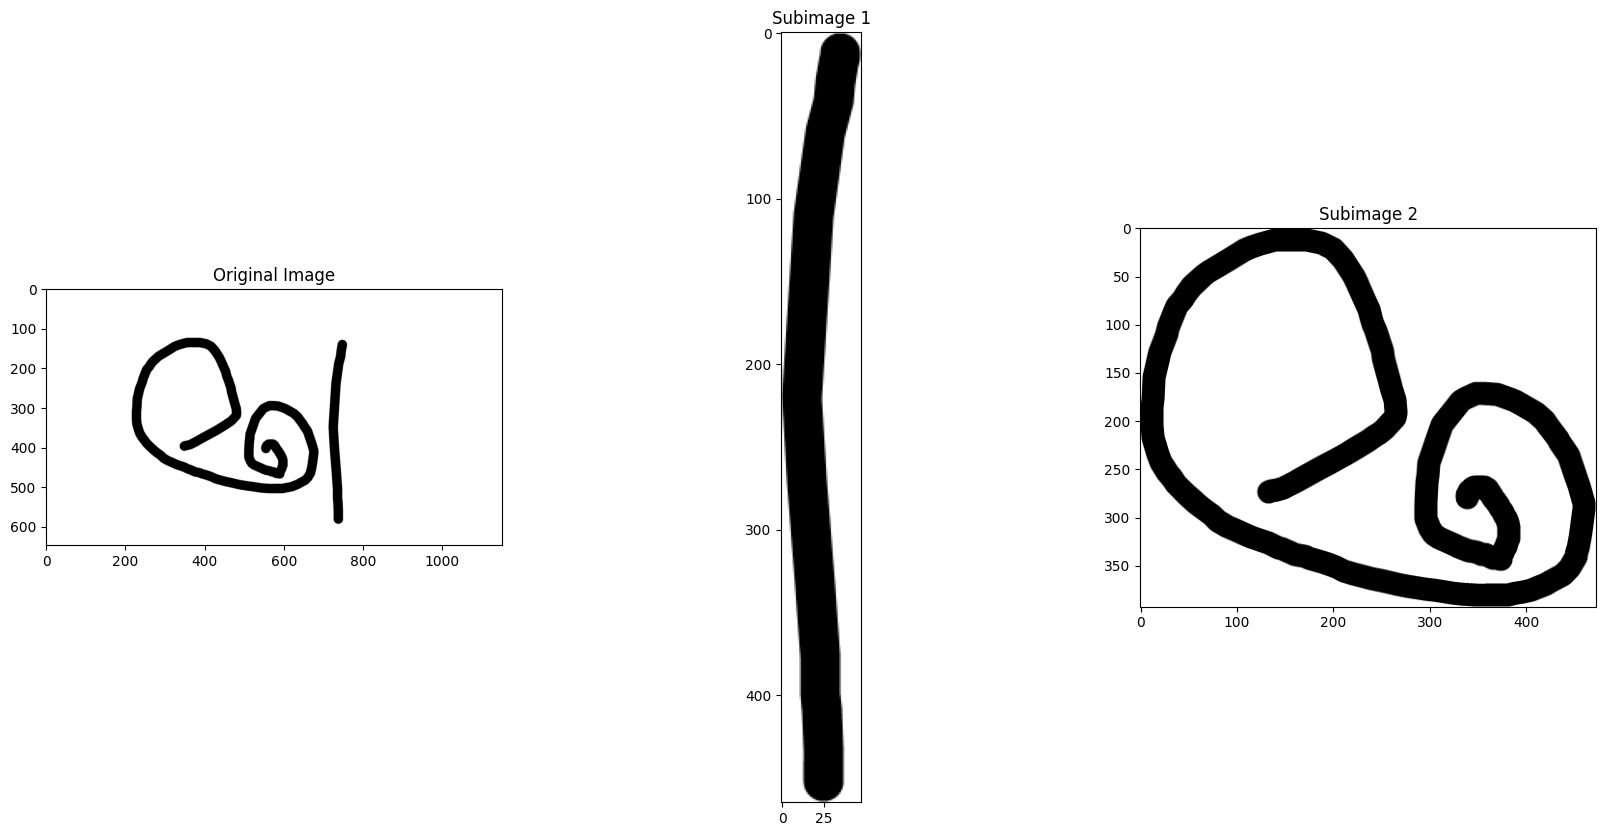

In [62]:
import cv2
import matplotlib.pyplot as plt

# Load the image and convert to grayscale
image = cv2.cvtColor(cv2.imread('test2.png'), cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Edge detection (Canny)
edges = cv2.Canny(blurred, threshold1=50, threshold2=150)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Calculate the minimum area threshold (e.g., 5% of the total image area)
total_area = image.shape[0] * image.shape[1]
min_area = 0.01 * total_area  # Set to 5% of total image area

# Initialize list to hold subimages
subimages = []

# Loop over all contours to create subimages first
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    subimage = image[y:y+h, x:x+w]
    
    # Only add subimage if it meets the minimum area requirement
    if w * h >= min_area:
        subimages.append(subimage)

# Plot original image and subimages in the same figure
fig, ax = plt.subplots(1, len(subimages) + 1, figsize=(20, 10))
ax[0].imshow(image)
ax[0].set_title('Original Image')
for i, subimage in enumerate(subimages):
    ax[i + 1].imshow(subimage)
    ax[i + 1].set_title(f'Subimage {i + 1}')
plt.show()


Time for Subimage 1: 0.00 seconds


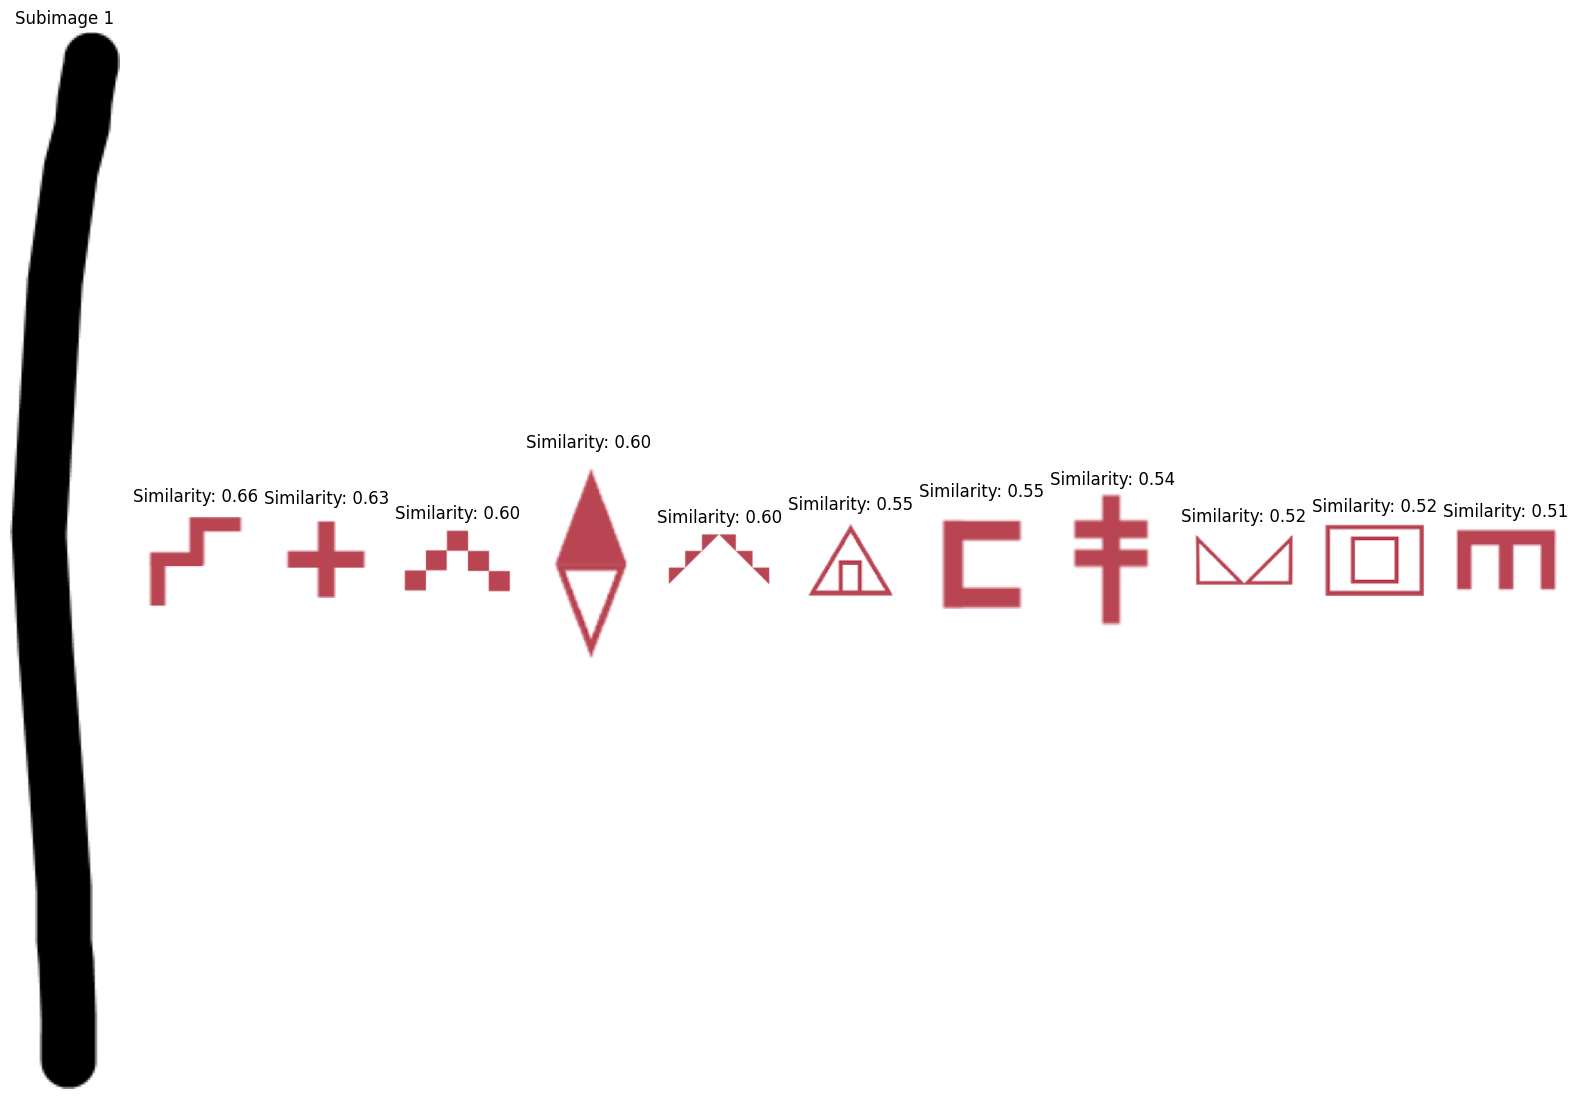

Time for Subimage 2: 0.00 seconds


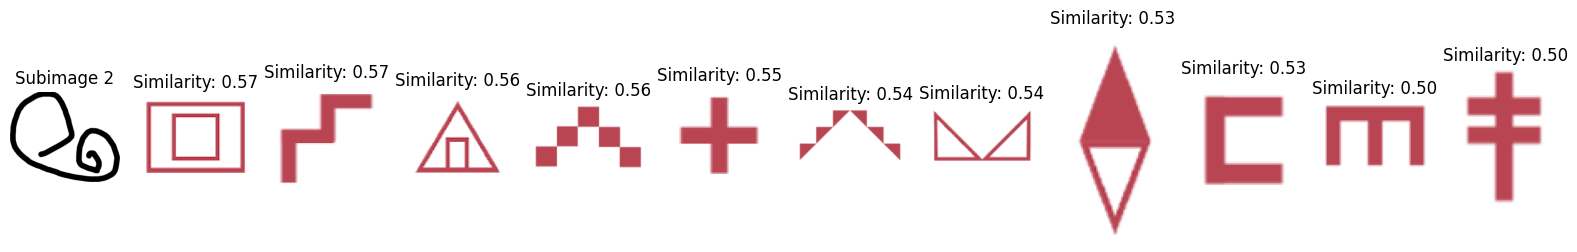

In [67]:
import time 
for idx, subimage in enumerate(subimages):
    # Convert subimage to vector
    test_vec = img2vec(subimage)
    
    # Compute cosine similarity with each symbol
    start = time.time()
    cosine_similarities = [cosine_similarity(test_vec, vec) for vec in symbols_vecs]
    stop = time.time()
    print(f"Time for Subimage {idx+1}: {stop - start:.2f} seconds")

    # Rank symbols by similarity
    ranking = np.argsort(cosine_similarities)[::-1]

    # Plot test subimage and top-ranked symbols
    n_symbols = len(symbols_vecs)
    fig, axs = plt.subplots(1, n_symbols + 1, figsize=(20, 20))
    axs[0].imshow(subimage)
    axs[0].axis('off')
    axs[0].set_title(f'Subimage {idx+1}')
    
    # Display each symbol with similarity score
    for i in range(n_symbols):  # Show top 5 matches or total symbols
        symbol = cv2.cvtColor(cv2.imread(glob(glob_path)[ranking[i]]), cv2.COLOR_BGR2RGB)
        axs[i + 1].imshow(symbol)
        axs[i + 1].axis('off')
        axs[i + 1].set_title(f'Similarity: {cosine_similarities[ranking[i]]:.2f}')
    
    plt.show()

Time: 4.0734593868255615


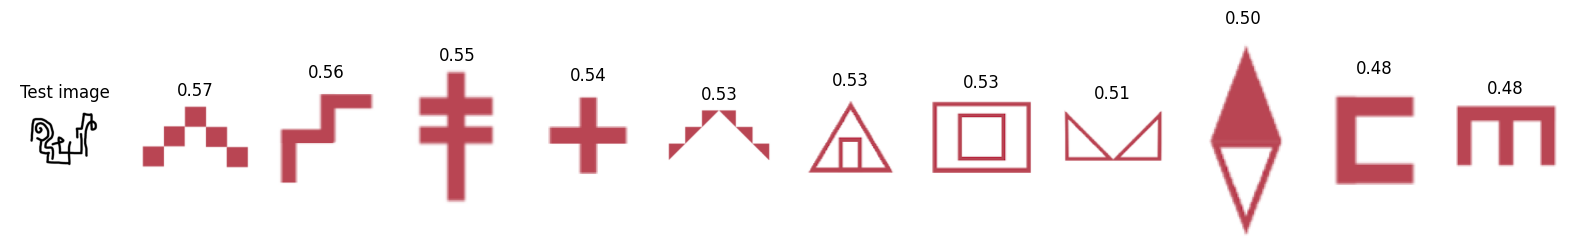

In [ ]:
import time



# load test image
image = cv2.cvtColor(cv2.imread('test2.png'), cv2.COLOR_BGR2RGB)
# lower the resolution of the image and keep the aspect ratio
#aspect_ratio = image.shape[1] / image.shape[0]
#image = cv2.resize(image, (128, int(128 / aspect_ratio)))

# compute cosine similarity between test image and each symbol and plot the ranking
# intialize time
start = time.time()
test_vec = img2vec(image)
stop = time.time()
print(f"Time: {stop-start}")
cosine_similarities = [cosine_similarity(test_vec, vec) for vec in symbols_vecs]
ranking = np.argsort(cosine_similarities)[::-1]

n_symbols = len(symbols_vecs)

fig, axs = plt.subplots(1, n_symbols+1, figsize=(20, 20))
axs[0].imshow(image)
axs[0].axis('off')
axs[0].set_title('Test image')
for i in range(n_symbols):
    symbol = cv2.cvtColor(cv2.imread(glob(glob_path)[ranking[i]]), cv2.COLOR_BGR2RGB)
    # plot the similarity score and the symbol
    axs[i+1].imshow(symbol)
    axs[i+1].axis('off')
    axs[i+1].set_title(f'{cosine_similarities[ranking[i]]:.2f}')
plt.show()


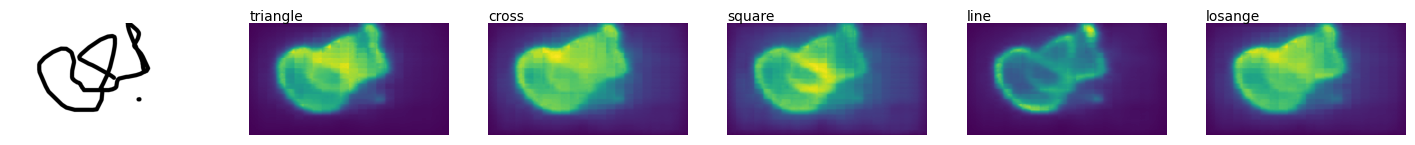

In [24]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor_seg = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model_seg = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

from PIL import Image
import requests


path = "test2.png"

image = Image.open(path)
# convert to jpeg imagefile
image = image.convert("RGB")


prompts = [ "triangle", 'cross', 'square', 'line', 'losange']
import torch
import matplotlib.pyplot as plt

inputs = processor_seg(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model_seg(**inputs)
preds = outputs.logits.unsqueeze(1)

# resize the outputs
preds = nn.functional.interpolate(
    outputs.logits.unsqueeze(1),
    size=(image.size[1], image.size[0]),
    mode="bilinear"
)

_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];